<a href="https://colab.research.google.com/github/SangMin316/EEG_Data/blob/main/220907_TTI_Pretext_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


augmentation for single channel

In [2]:
import numpy as np
def MAF(x,window):
    noise = np.convolve(x, np.ones(window),'same')/window
    x = x - noise
    return x

def asln(x,a,b):
    T = len(x)
    noise = a*np.linspace(0,10,T) - b*np.ones(T)
    n = np.random.randint(2)
    if n == 0:
        new_signals = x + noise
    else:
        new_signals = x - noise
    return new_signals

def apn(x,c,d):
    T = len(x)
    noise =np.sin(np.linspace(-np.pi+d,np.pi+d,T))
    new_signals = x + c*noise
    return new_signals

In [3]:
def data_aug(x,window,a,b,c,d):
    sequence_length = 500
    x = np.reshape(x,(1,sequence_length))
    x = np.squeeze(x)
    x_maf = MAF(x,window)
    x_asln = asln(x,a,b)
    x_apn = apn(x,c,d)
    x = np.array([x ,x_maf, x_asln, x_apn])
    x = np.squeeze(x)
    #one-hot encoding
    label = np.eye(4)
    return x, label
    

In [6]:
sample_data = np.load('16079_4.npy')

In [12]:
x,y = data_aug(sample_data,20,5,0.3,25,0)
print(x.shape)
print(y)

(4, 500)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Plot signals

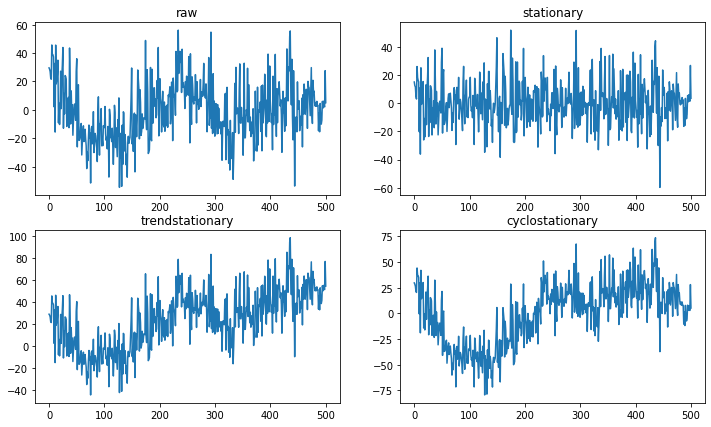

In [13]:
import matplotlib.pyplot as plt

t = np.linspace(0,500,500)
plt.figure(figsize =(12, 7))
label = ['raw', 'stationary','trendstationary','cyclostationary']

for i in range(4):
  y = x[i]
  plt.subplot(2, 2, i+1)
  plt.plot(t,y)
  plt.title(label[i])
  
plt.show()  

augmentation for multiple channels 

In [14]:
import numpy as np
def MAF(x,window):
    sample_num, T = x.shape
    for i in range(sample_num):
      noise = np.convolve(x[i], np.ones(window),'same')/window
      x[i] = x[i] - noise
    return x

def asln(x,a,b):

    C,T = x.shape
    noise = a*np.linspace(0,10,T) - b*np.ones(T)
    noise = noise*np.ones((C,1))
    n = np.random.randint(2)
    if n == 0:
      new_signals = x + noise
    else:
      new_signals = x - noise
    return new_signals

def apn(x,c,d):
    C,T = x.shape
    noise = np.linspace(-np.pi+d,np.pi+d,T) - d*np.ones(T)
    noise = c*np.sin(noise)*np.ones((C,1))
    new_signals = x + noise
    return new_signals

load_dataset

In [15]:
import glob
class load_dataset():
    def __init__(self, sbj_idx):
        self.sbj_idx = sbj_idx
        self.sequence_length = 500
        self.path = '/content/drive/MyDrive/sleep_edfx/500npy'

    def load_data(self):
        X = []
        data_list = glob.glob(self.path+'/**')

        for sbj_idx in range(self.sbj_idx):
            data = np.load(data_list[sbj_idx])
            X.append(data)
        return  np.array(X)

    def augmented_data(self,x,window,a,b,c,d):
      X = []
      Y = []
      x = np.reshape(x,(self.sbj_idx,1,self.sequence_length))
      x = np.squeeze(x)
      x_maf = MAF(x,window)
      x_asln = asln(x,a,b)
      x_apn = apn(x,c,d)
      X.append(x)
      X.append(x_maf)
      X.append(x_asln)
      X.append(x_apn)

      #one-hot encoding
      original = [1,0,0,0]
      s_maf = [0,1,0,0]
      s_asln = [0,0,1,0]
      s_apn = [0,0,0,1]

      Y.append(original*np.ones((self.sbj_idx,1)))
      Y.append(s_maf*np.ones((self.sbj_idx,1)))
      Y.append(s_asln*np.ones((self.sbj_idx,1)))
      Y.append(s_apn*np.ones((self.sbj_idx,1)))
      
      X = np.array(X)
      X = X.reshape(4*self.sbj_idx,1,self.sequence_length)

      Y = np.array(Y)
      Y = Y.reshape(4*self.sbj_idx,4)
      
      return X,Y 


    def call(self, fold):
        X = self.load_data()
        X,Y = self.augmented_data(X,20,2,0.3,20,0)
        print(X.shape)
        print(Y.shape)
        num_samples = int(X.shape[0]/(5)) # Samples per fold

        # Set training/validation/testing data indices
        rand_idx = np.random.RandomState(seed=981220).permutation(X.shape[0])
        test_idx = rand_idx[(fold - 1) * num_samples:fold * num_samples]
        train_idx = np.setdiff1d(rand_idx, test_idx)
        valid_idx = np.random.RandomState(seed=3940).permutation(train_idx.shape[0])[:28]
        valid_idx = train_idx[valid_idx]
        train_idx = np.setdiff1d(train_idx, valid_idx)


        X_tr, X_vl, X_ts = X[train_idx, ...], X[valid_idx, ...], X[test_idx, ...]
        Y_tr, Y_vl, Y_ts = Y[train_idx, ...], Y[valid_idx, ...], Y[test_idx, ...]

        return (X_tr, Y_tr), (X_vl, Y_vl), (X_ts, Y_ts)

EEGLoader

In [16]:
from torch.utils.data import Dataset
import torch

class EEGLoader(Dataset):
    def __init__(self, data, device):
        X_data, y_data = data

        self.x_data = torch.Tensor(X_data).to(device)
        self.y_data = torch.Tensor(y_data).to(device)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, index):
        return self.x_data[index,:], self.y_data[index,:]

    def getallitem(self):
        return self.x_data, self.y_data

model

In [17]:
pip install separableconv-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import torch
import torch.nn as nn
import separableconv.nn as nns


class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Regularizer
        #self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        self.activation = nn.LeakyReLU()

        self.softmax = nn.Softmax()
        self.conv1t = nns.SeparableConv1d(1,16,10,padding ='same') # (in_channels, out_channels, kernel size,,,)
        self.conv1s = nn.Conv1d(16,16,self.channels)
        self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') 
        self.conv2s = nn.Conv1d(32,32,self.channels)
        self.conv3t = nns.SeparableConv1d(32,64,10,padding ='same')
        self.conv3s = nn.Conv1d(64,64,self.channels)
        
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.3)

        # Decision making
        self.Linear = nn.Linear(56000,4) # 
      
         
        
    def embedding(self, x, random_mask=False):
        # print(x.shape)
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        

        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1  )
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

In [31]:
import os

# batch size
batch_size = 2
learning_rate = 0.000001
epochs = 14

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"



In [21]:
print(device)

cuda:0


In [22]:
from torch.utils.data import DataLoader
#dataset 몇개를 사용할 것인지 결정 
idx = 1000
tr, va, te = load_dataset(idx).call(5)

(4000, 1, 500)
(4000, 4)


In [32]:
# dataset loader
trainEEG = EEGLoader(tr, device)
valEEG = EEGLoader(va,device)
print("tainLoader")
trainLoader = DataLoader(trainEEG, batch_size = batch_size, shuffle=True)
valLoder = DataLoader(valEEG, batch_size = batch_size, shuffle=True)

tainLoader


In [24]:
class Temporal_Trend_Identification_Task_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, device = None):
        super().__init__()
        self.device = device

    def forward(self, batch, encoder, train):
        x,y = batch
        CrossEL = torch.nn.CrossEntropyLoss()
        rept = encoder.forward(torch.Tensor(x))
        # print('y:',y.shape)
        # print('x:',rept.shape)
        loss = CrossEL(rept, torch.Tensor(y))

        if train:
            loss.backward(retain_graph=True)
        return loss

In [33]:
model = feature_extractor3().to(device)
#model.to(device)
criterion = Temporal_Trend_Identification_Task_Loss(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
print(model)

feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=None)
  (conv1t): SeparableConv1d(
    (dwconv): Conv1d(1, 1, kernel_size=(10,), stride=(1,), padding=same)
    (dwconv_normalization): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dwconv_activation): ReLU()
    (pwconv): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
    (pwconv_normalization): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pwconv_activation): ReLU()
  )
  (conv1s): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
  (conv2t): SeparableConv1d(
    (dwconv): Conv1d(16, 16, kernel_size=(10,), stride=(1,), padding=same, groups=16)
    (dwconv_normalization): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dwconv_activation): ReLU()
    (pwconv): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
    (pwconv_normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, tra

learing

In [34]:
import matplotlib.pyplot as plt

loss_tr = []
loss_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    for batch_idx, batch in enumerate(trainLoader):
        loss_batch = criterion.forward(batch, model, train = True)
        optimizer.step()
        loss_ep += loss_batch
    loss_ep =  loss_ep/4/idx*5/3
    loss_tr.append(loss_ep.item())

    loss_ep_val = 0
    for batch_idx, batch in enumerate(valLoder):
        loss_batch_val = criterion.forward(batch, model, train = False)
        loss_ep_val += loss_batch_val
    
    loss_ep_val =  loss_ep_val/idx/4*5
    loss_val.append(loss_ep_val.item())
    print("epoch : ", epoch, "   train loss : ", loss_ep.item(), "    val loss : ", loss_ep_val.item())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch :  0    train loss :  0.9133847951889038     val loss :  0.023645201697945595
epoch :  1    train loss :  0.8424844741821289     val loss :  0.023558691143989563
epoch :  2    train loss :  0.7737693786621094     val loss :  0.021561328321695328
epoch :  3    train loss :  0.7276619672775269     val loss :  0.020346639677882195
epoch :  4    train loss :  0.6986038684844971     val loss :  0.020770711824297905
epoch :  5    train loss :  0.6836955547332764     val loss :  0.019325241446495056
epoch :  6    train loss :  0.6733548045158386     val loss :  0.018475886434316635
epoch :  7    train loss :  0.6683288812637329     val loss :  0.01832776516675949
epoch :  8    train loss :  0.6645386219024658     val loss :  0.01889132149517536
epoch :  9    train loss :  0.6628965735435486     val loss :  0.018625449389219284
epoch :  10    train loss :  0.6614371538162231     val loss :  0.018461301922798157
epoch :  11    train loss :  0.6592187285423279     val loss :  0.01861865073

[0.9133847951889038, 0.8424844741821289, 0.7737693786621094, 0.7276619672775269, 0.6986038684844971, 0.6836955547332764, 0.6733548045158386, 0.6683288812637329, 0.6645386219024658, 0.6628965735435486, 0.6614371538162231, 0.6592187285423279, 0.6573305726051331, 0.6557943820953369]
[0.023645201697945595, 0.023558691143989563, 0.021561328321695328, 0.020346639677882195, 0.020770711824297905, 0.019325241446495056, 0.018475886434316635, 0.01832776516675949, 0.01889132149517536, 0.018625449389219284, 0.018461301922798157, 0.01861865073442459, 0.01796761341392994, 0.018014198169112206]


Text(0.5, 1.0, 'val_loss')

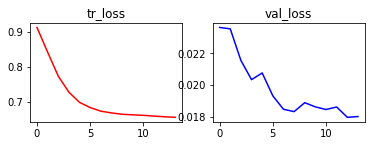

In [36]:
print(loss_tr)
print(loss_val)
plt.subplot(2,2,1)
plt.plot(range(epochs), loss_tr, label='Loss', color='red')
plt.title('tr_loss')

plt.subplot(2,2,2)
plt.plot(range(epochs), loss_val, label='Loss', color='blue')
plt.title('val_loss')
